In [1]:
# Se cargan las dependencias necesarias
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[[18439, -24426, -66], [17593, -18459, 1530], [16799, -2399, 12375], [18972, 17545, 19345], [19010, 27945, 11632], [14558, 21964, -7770], [13722, -11681, -15383], [17493, -21619, -4932], [18743, -24620, 296], [17467, -17527, 1202], [16909, -922, 13031], [19128, 18437, 20105], [18969, 27464, 10878], [13982, 21284, -9449], [10631, 3801, -18901], [14718, -12733, -13389], [18577, -24810, 33], [17059, -16669, 1765], [16983, 1746, 14525], [19801, 21197, 19686], [18110, 28366, 7602], [13270, 19140, -11506], [11259, 979, -17810], [15254, -15443, -12872], [17828, -22972, -3118], [18207, -24322, 3355], [17325, 4856, 15532], [19509, 23224, 18104], [18060, 27415, 5672], [12901, 17015, -13403], [10962, -796, -18910], [15950, -16980, -10624], [18115, -23304, -2394], [18382, -23085, 532], [16780, -12328, 4195], [19985, 24590, 19375], [16628, 26910, 2083], [11981, 13893, -15638], [11686, -3854, -17990], [16585, -18745, -8951], [18665, -24508, -918], [17661, -21873, -690], [16933, -9339, 7148], [18145,

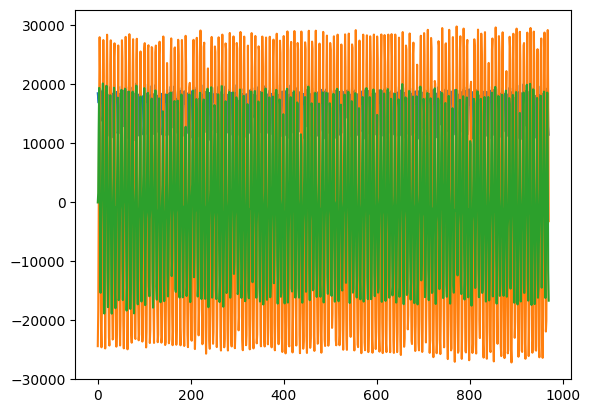

In [3]:
RutaFile="/content/drive/MyDrive/pruebas/Training/No lubrication.json.5cdkuekr.ingestion-7689984996-rpt7l.json"
dataframe = pd.read_json(RutaFile)
#print(dataframe.to_string())
Valores = dataframe.iloc[:,:].values
#print(Valores.shape)
#print(Valores)
print(Valores[7,2][0:-1])

DatosOri1=Valores[7,2][0:-1]
Datos1=np.array(DatosOri1)
print(Datos1.shape)
plt.plot(Datos1)

In [4]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ruta a la carpeta donde están los archivos JSON
directory = '/content/drive/MyDrive/pruebas/Training/'

# Listar y ordenar los archivos
files = os.listdir(directory)
files.sort()
cantidadFiles = len(files)

# Número de clases y archivos por clase
num_classes = 4
files_per_class = cantidadFiles // num_classes  # Asumiendo 120 archivos distribuidos en 4 clases

# Parámetros del enventanado
sequence_length = 100  # Tamaño de la ventana
sequence_stride = 10   # Paso de la ventana deslizante

# Para almacenar las características y etiquetas
all_spectral_features = []
all_labels = []

# Función para extraer características espectrales
def extract_spectral_features(data, fs=49):
    features = []
    for axis_data in data.T:
        fft_result = np.fft.fft(axis_data)
        freqs = np.fft.fftfreq(len(axis_data), 1/fs)
        magnitude = np.abs(fft_result)
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]
        dominant_freq = positive_freqs[np.argmax(positive_magnitude)]
        total_energy = np.sum(positive_magnitude**2)
        low_band = np.sum(positive_magnitude[(positive_freqs < 10)]**2)
        mid_band = np.sum(positive_magnitude[(positive_freqs >= 10) & (positive_freqs < 20)]**2)
        high_band = np.sum(positive_magnitude[(positive_freqs >= 20)]**2)
        mean_amplitude = np.mean(positive_magnitude)
        std_amplitude = np.std(positive_magnitude)
        features.append([dominant_freq, total_energy, low_band, mid_band, high_band, mean_amplitude, std_amplitude])
    return np.concatenate(features)

# Procesar cada archivo individualmente
for idx, file in enumerate(files):
    # Ruta completa del archivo
    RutaFile = os.path.join(directory, file)

    # Leer el archivo JSON
    dataframe = pd.read_json(RutaFile)
    Valores = dataframe.iloc[:, :].values
    DatosOriDF = Valores[7, 2][0:-1]  # Extraer los datos de aceleración
    DatosOriNP = np.array(DatosOriDF)

    # Asegurarse de que los datos tengan la longitud correcta (970 muestras)
    Datos = DatosOriNP[0:970]
    Datos = Datos.reshape(-1, 3)  # Forma (970, 3), para X, Y, Z

    # Determinar la clase del archivo
    current_class = idx // files_per_class  # Clase correspondiente (0 a num_classes-1)

    # Crear ventanas deslizantes
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=Datos,
        targets=None,
        sequence_length=sequence_length,
        sequence_stride=sequence_stride,
        batch_size=32,
    )

    # Convertir a array numpy
    X_windows = np.concatenate([x.numpy() for x in dataset], axis=0)

    # Extraer características espectrales para cada ventana
    n_samples, _, n_axes = X_windows.shape
    spectral_features = np.zeros((n_samples, 7 * n_axes))
    for i in range(n_samples):
        spectral_features[i, :] = extract_spectral_features(X_windows[i])

    # Crear etiquetas para estas ventanas
    labels = np.full((n_samples,), current_class)

    # Agregar las características y etiquetas al conjunto total
    all_spectral_features.append(spectral_features)
    all_labels.append(labels)

# Concatenar todas las características y etiquetas
all_spectral_features = np.vstack(all_spectral_features)
all_labels = np.concatenate(all_labels)

# Estandarizar las características
scaler = StandardScaler()
all_spectral_features_scaled = scaler.fit_transform(all_spectral_features)

print("Forma final de las características escaladas:", all_spectral_features_scaled.shape)
print("Forma final de las etiquetas:", all_labels.shape)

# Convertir etiquetas a categóricas
all_labels_categorical = tf.keras.utils.to_categorical(all_labels, num_classes=num_classes)



Forma final de las características escaladas: (10560, 21)
Forma final de las etiquetas: (10560,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 19, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 17, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,548 (33.39 KB)

 Trainable params: 8,548 (33.39 KB)

 Non-trainable params: 0 (0.00 B)

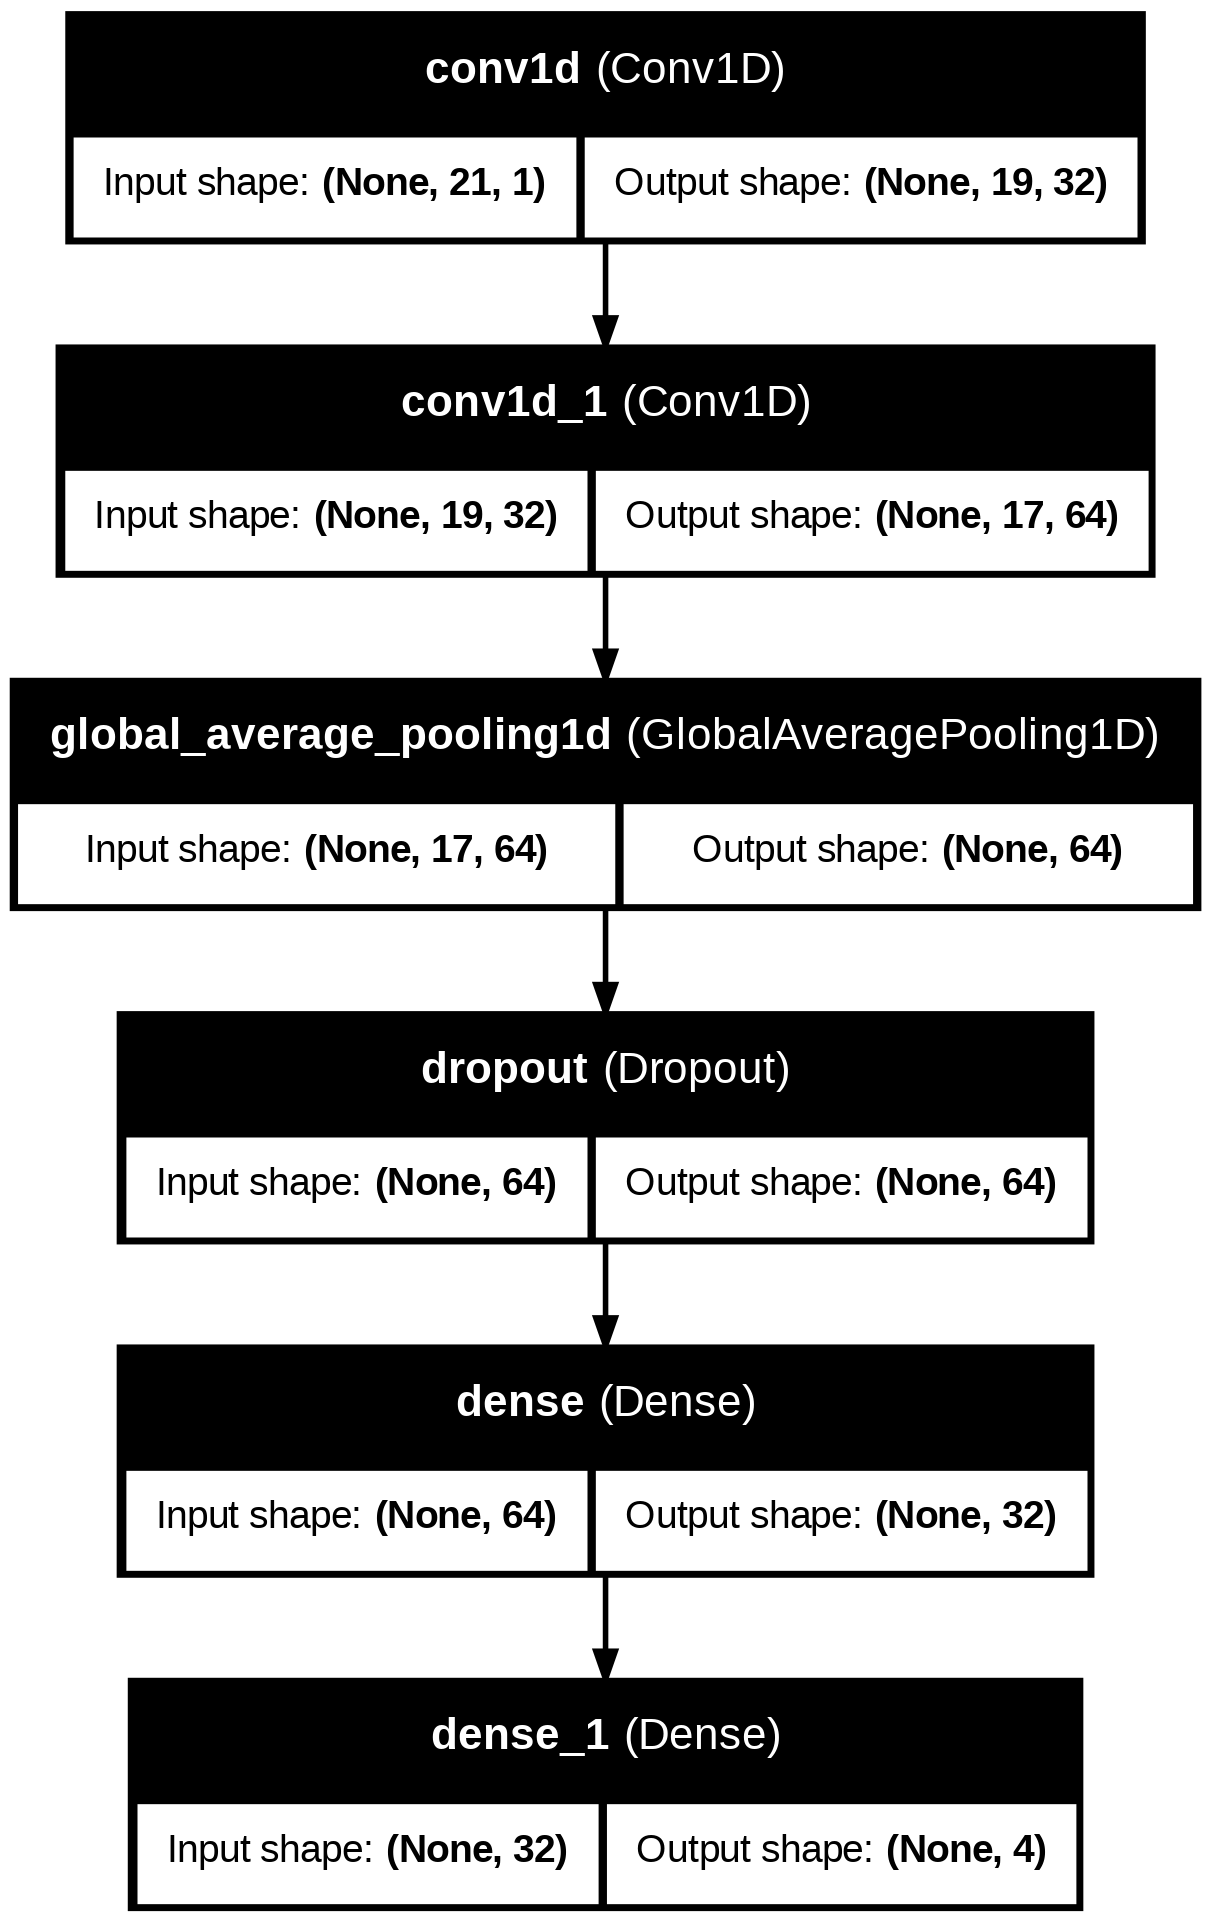

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, GlobalAveragePooling1D, Dropout

# Modelo convolucional
modelo_cnn = Sequential()
modelo_cnn.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(21, 1)))  # Entrada en formato (21, 1)
modelo_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelo_cnn.add(GlobalAveragePooling1D())  # Reduce las dimensiones
modelo_cnn.add(Dropout(0.5))  # Regularización
modelo_cnn.add(Dense(32, activation='relu'))
modelo_cnn.add(Dense(4, activation='softmax'))  # 4 clases

modelo_cnn.summary()

# Compilar el modelo
modelo_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

keras.utils.plot_model(modelo_cnn, to_file='model_plot3.png', show_shapes=True, show_layer_names=True)


In [6]:
from sklearn.model_selection import train_test_split

# Dividir datos en conjunto de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(
    all_spectral_features_scaled, all_labels_categorical, test_size=0.20, random_state=42
)


In [7]:
X_train_reshaped = X_train.reshape(-1, 21, 1)  # Cambia -1 a tu tamaño de batch si es necesario

# Entrenamiento
historia = modelo_cnn.fit(X_train, y_train, epochs=30, batch_size=32)

Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4515 - loss: 1.1535
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8109 - loss: 0.5378
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8650 - loss: 0.3760
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8917 - loss: 0.3050
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9076 - loss: 0.2677
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9178 - loss: 0.2293
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9269 - loss: 0.2064
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9338 - loss: 0.1985
Epoch 9/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9391 - loss: 0.1712
Epoch 10/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9417 - loss: 0.1625
Epoch 11/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9470 - loss: 0.1506
Epoch 12/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

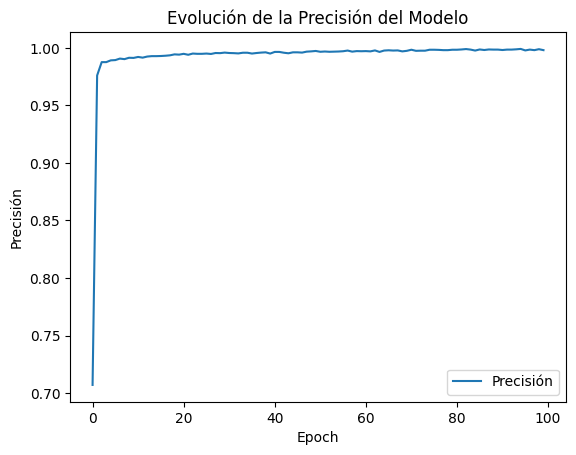

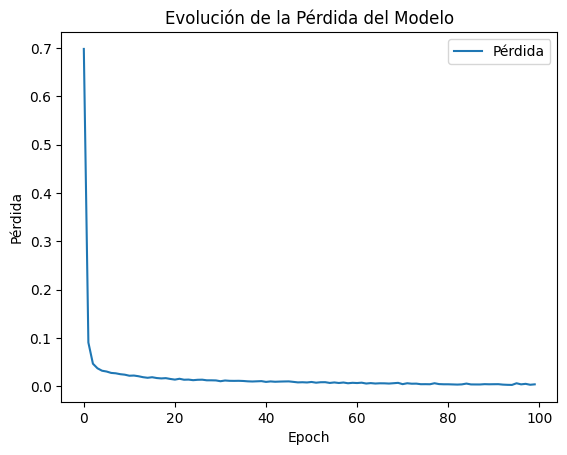

In [ ]:
plt.plot(historia.history['accuracy'], label='Precisión')
plt.title('Evolución de la Precisión del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Precisión')

plt.legend(loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(historia.history['loss'], label='Pérdida')
plt.title('Evolución de la Pérdida del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Pérdida')
plt.legend(loc='upper right')
plt.show()

In [8]:
modelo_cnn.evaluate(X_val, y_val)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9869 - loss: 0.0356


[0.03413459286093712, 0.9895833134651184]

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       528
           1       1.00      0.96      0.98       530
           2       1.00      1.00      1.00       524
           3       1.00      1.00      1.00       530

    accuracy                           0.99      2112
   macro avg       0.99      0.99      0.99      2112
weighted avg       0.99      0.99      0.99      2112

[[526   2   0   0]
 [ 20 510   0   0]
 [  0   0 524   0]
 [  0   0   0 530]]


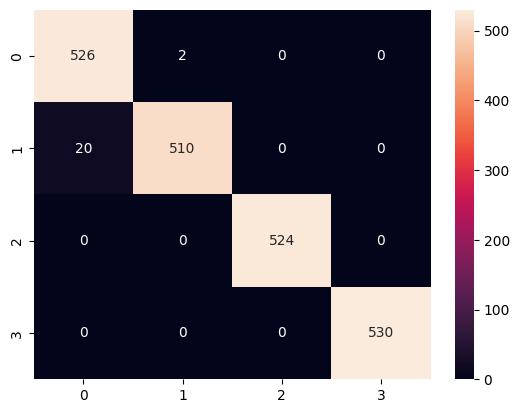

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

ypredic=modelo_cnn.predict(X_val)

y_test_class = np.argmax(y_val,axis=1)
y_pred_class = np.argmax(ypredic,axis=1)

#Accuracy of the predicted values
print(classification_report(y_test_class, y_pred_class)) # Precision , Recall, F1-Score & Support
cm = confusion_matrix(y_test_class, y_pred_class)
print(cm)
# visualize the confusion matrix in a heat map
df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Ruta del nuevo archivo JSON
nuevo_archivo = '/content/drive/MyDrive/pruebas/Training/No lubrication.json.5cdlmeh3.ingestion-7689984996-86jlz.json'

# Leer el archivo JSON
dataframe = pd.read_json(nuevo_archivo)
Valores = dataframe.iloc[:, :].values
DatosOriDF = Valores[7, 2][0:-1]  # Extraer los datos de aceleración
DatosOriNP = np.array(DatosOriDF)

# Asegurarse de que los datos tengan la longitud correcta (970 muestras como en los datos originales)
Datos = DatosOriNP[0:970]
Datos = Datos.reshape(-1, 3)  # Forma (970, 3), para X, Y, Z

# Parámetros del enventanado (mismos que en el entrenamiento)
sequence_length = 100
sequence_stride = 10

# Crear ventanas deslizantes
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=Datos,
    targets=None,
    sequence_length=sequence_length,
    sequence_stride=sequence_stride,
    batch_size=32,
)

# Convertir las ventanas a un array numpy
X_windows = np.concatenate([x.numpy() for x in dataset], axis=0)

# Extraer características espectrales para las ventanas
def extract_spectral_features(data, fs=49):
    features = []
    for axis_data in data.T:
        fft_result = np.fft.fft(axis_data)
        freqs = np.fft.fftfreq(len(axis_data), 1/fs)
        magnitude = np.abs(fft_result)
        positive_freqs = freqs[:len(freqs)//2]
        positive_magnitude = magnitude[:len(magnitude)//2]
        dominant_freq = positive_freqs[np.argmax(positive_magnitude)]
        total_energy = np.sum(positive_magnitude**2)
        low_band = np.sum(positive_magnitude[(positive_freqs < 10)]**2)
        mid_band = np.sum(positive_magnitude[(positive_freqs >= 10) & (positive_freqs < 20)]**2)
        high_band = np.sum(positive_magnitude[(positive_freqs >= 20)]**2)
        mean_amplitude = np.mean(positive_magnitude)
        std_amplitude = np.std(positive_magnitude)
        features.append([dominant_freq, total_energy, low_band, mid_band, high_band, mean_amplitude, std_amplitude])
    return np.concatenate(features)

# Extraer características espectrales para todas las ventanas
n_samples, _, n_axes = X_windows.shape
spectral_features = np.zeros((n_samples, 7 * n_axes))
for i in range(n_samples):
    spectral_features[i, :] = extract_spectral_features(X_windows[i])

# Estandarizar las características espectrales (usar el scaler del entrenamiento)
spectral_features_scaled = scaler.transform(spectral_features)  # Usa el `scaler` ya entrenado

# Hacer predicciones con el modelo
predicciones = modelo_cnn.predict(spectral_features_scaled)

# Obtener la clase más probable para cada ventana
clases_predichas = np.argmax(predicciones, axis=1)

#print(f"Contenido de clases_predichas: {clases_predichas}")
#print(f"Forma de clases_predichas: {clases_predichas.shape}")

from collections import Counter

# Calcular la clase más frecuente manualmente
conteo_clases = Counter(clases_predichas)  # Contar ocurrencias de cada clase
prediccion_final = max(conteo_clases, key=conteo_clases.get)  # Clase con más ocurrencias

print(f"Predicción final para el archivo: Clase {prediccion_final}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicción final para el archivo: Clase 0


In [11]:
import shutil
# Guardar el modelo en formato SavedModel
modelo_cnn.export('/content/modelo')

# Comprimir el modelo
shutil.make_archive('/content/modelo', 'zip', '/content/modelo', '/content/modelo')

Saved artifact at '/content/modelo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  131990544252624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131989852022464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131989850871888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131989851459072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131989849684128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131989849684832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131989848148096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131989848148976: TensorSpec(shape=(), dtype=tf.resource, name=None)


'/content/modelo.zip'

In [ ]:
import os
directory = '/content/drive/MyDrive/pruebas/Testing/'
files = os.listdir(directory)
files.sort()
print(files)
cantidadFiles = len(files)

DatosVal=np.zeros((cantidadFiles*970,3))
i = 0
for file in files:
  RutaFile=directory + file
  dataframe = pd.read_json(RutaFile)
  Valores = dataframe.iloc[:,:].values
  DatosOriDF=Valores[7,2][0:-1]
  DatosOriNP=np.array(DatosOriDF)
  DatosVal[i*970:(i+1)*970] = DatosOriNP[0:970]
  i+=1
print(DatosVal.shape)
plt.plot(DatosVal)

In [ ]:
# Código para normalizar, sin embargo, se tienen mejores resultados sin hacer esta operación
#scaler3 = MinMaxScaler()
#scaler3.fit(DatosVal)
#DatosValN=scaler3.transform(DatosVal)
DatosValN=DatosVal
plt.plot(DatosValN)

In [ ]:

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=DatosVal,               # Datos originales de validación
    targets=None,        # Etiquetas correspondientes
    sequence_length=100,      # Longitud de la ventana
    sequence_stride=10,       # Paso entre ventanas
    batch_size=32
)

X_val_windows = []
y_val_windows = []
for batch in val_dataset:
    X_batch = batch
    X_val_windows.append(X_batch.numpy())


X_val_windows = np.concatenate(X_val_windows, axis=0)  # (n_samples, 100, 3)
#y_val_windows = np.concatenate(y_val_windows, axis=0)  # (n_samples,)

In [ ]:
# Inicializar matriz para características espectrales de validación
n_samples_val = X_val_windows.shape[0]
spectral_features_val = np.zeros((n_samples_val, 7 * 3))  # 7 características * 3 ejes (X, Y, Z)

for i in range(n_samples_val):
    reshaped_data = X_val_windows[i, :, :].reshape(100, 3)
    spectral_features_val[i, :] = extract_spectral_features(reshaped_data)

In [ ]:
spectral_features_val_scaled = scaler.transform(spectral_features_val)
